# 필요 라이브러리 가져오기

In [1]:
from PIL import Image                                  #python image libray

%matplotlib inline                                      
import matplotlib
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset,DataLoader

import numpy as np

import torchvision
from torchvision import transforms

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


# Tensor
![image.png](img_folder/img1.png)

# 데이터 전처리

In [2]:
trans = transforms.Compose([transforms.Resize((100,100)),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                           ])

# Normalize = scaling + centering
#scaling : 데이터의 scale을 줄여줌.
#centering : 데이터의 중심을 원점으로 맞춰주는 것.

trainset = torchvision.datasets.ImageFolder(root= "C:\\Users\\negga\\Desktop\\AiTest\\traindata\\pipe",transform=trans)




In [3]:
len(trainset)                 # trainset 데이터 개수


trainset.__getitem__(1)       # trainset 에 있는 2번째 데이터 가져와서 출력

(tensor([[[-0.6078, -0.2941, -0.1922,  ...,  0.1059, -0.0510, -0.8039],
          [-0.5843, -0.2784, -0.1765,  ...,  0.1373, -0.0118, -0.7961],
          [-0.5608, -0.2471, -0.1686,  ...,  0.1765,  0.0353, -0.7725],
          ...,
          [-0.2549,  0.1765,  0.2706,  ..., -0.2000, -0.3098, -0.8667],
          [-0.2784,  0.1529,  0.2157,  ..., -0.2314, -0.3412, -0.8824],
          [-0.3098,  0.1137,  0.2235,  ..., -0.2706, -0.3725, -0.8824]],
 
         [[-0.5922, -0.2863, -0.1529,  ...,  0.1373, -0.0039, -0.7725],
          [-0.5843, -0.2784, -0.1529,  ...,  0.1608,  0.0196, -0.7647],
          [-0.5608, -0.2549, -0.1451,  ...,  0.2000,  0.0510, -0.7569],
          ...,
          [-0.2549,  0.1843,  0.2863,  ..., -0.2549, -0.3647, -0.8902],
          [-0.2784,  0.1529,  0.2235,  ..., -0.2549, -0.3569, -0.8824],
          [-0.3098,  0.1137,  0.2157,  ..., -0.2941, -0.3804, -0.8824]],
 
         [[-0.5922, -0.2706, -0.2471,  ...,  0.2549,  0.1059, -0.7020],
          [-0.5294, -0.2157,

In [4]:
classes = trainset.classes

classes


['connector', 'crack', 'joint', 'normal', 'sendimentation', 'tubedamage']

In [5]:
trainloader = DataLoader(trainset,
                        batch_size=4,
                        shuffle =True,
                        num_workers = 4)

len(trainloader)


16779

In [6]:
dataiter = iter(trainloader)
images,labels = dataiter.next()
print(labels)

tensor([1, 3, 0, 0])


In [7]:
def imgshow(img):
    img=img/2 + 0.5     # unnormalize
    np_img = img.numpy()
    plt.figure(figsize=(15,15))
    plt.imshow(np.transpose(np_img,(1,2,0)))
    
    print(np_img.shape)
    print((np.transpose(np_img,(1,2,0))).shape)

(3, 104, 410)
(104, 410, 3)
torch.Size([4, 3, 100, 100])
torch.Size([3, 104, 410])
crack normal connector connector 


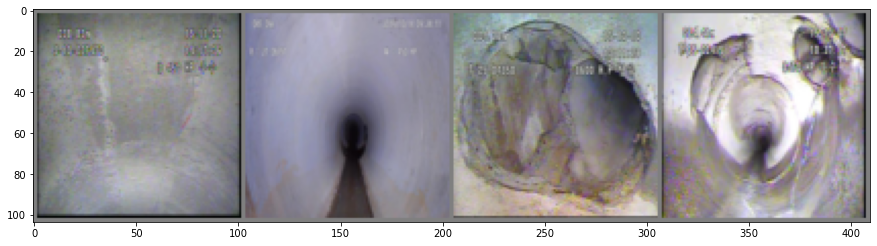

In [8]:

imgshow(torchvision.utils.make_grid(images,nrow=4))
print(images.shape)
print((torchvision.utils.make_grid(images)).shape)
print("".join("%5s "%classes[labels[j]] for j in range(4) ))



![image.png](img_folder/img2.png)

![image.png](img_folder/img3.png)

In [9]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)    # 입력 채널 수, 출력 채널 수, 필터의 크기
        
        #첫번째 파라미터 input_channel_size(입력데이터) RGB_depth를 의미
        #두번째 파라미터 output_volume_size(출력데이터) 첫번째 신경망 거쳐 몇장의 필터를 만들어내고싶은지
        #세번째 파라미터 kernel_size 이며 Filter_size 라고 부르며 filter의 사이즈를 정의하는 것 5 입력시 5*5필터생성
        # 위는 없지만 stride parameter 가 있으며 필터 이동 간격이다 default는 stride=1 지정
        
        
        self.pool = nn.MaxPool2d(2, 2)  
        self.conv2 = nn.Conv2d(6, 16, 5) 
        
        self.fc1 = nn.Linear(16 * 22 * 22, 120)         
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        #print("input : ", x.size())                        #input size =>4,3,32,32              #input size 4,3,100,100
        x = self.pool(F.relu(self.conv1(x)))              
        #print("conv1 후 풀링 : ",x.size())                 #4,6,14,14                           #4,6,48,48
        x = self.pool(F.relu(self.conv2(x)))
        #print("conv2 후 풀링 : ",x.size())                 #4,16,5,5                            #4,16,22,22
        
        x = x.view(-1, 16 * 22 * 22)    #4 ,400              # view() => reshape 역할  선형형태로 차원 감소 시킴 , 아래 코드에서 손실값을 계산하기위해 crossEntropyLoss알고리즘을 사용하는데 텐서의 크기가 1차원이어야 하기때문에 차원을 감소시킴
        #print(x.size())          
        
        x = F.relu(self.fc1(x))
        #print(x.size())
        
        x = F.relu(self.fc2(x))
        #print(x.size())
        
        x = self.fc3(x)
        #print(x.size())
        
        return x


net = Net()

In [10]:
conv2dweight= nn.Conv2d(3, 6, 5) 

conv1dweight = nn.Conv2d(3,6,5)
print("conv1: ",conv1dweight.weight)
print("conv2: ",conv2dweight.weight) #파라미터를 지정해주면 지정한 파라미터에 크기로 필터를 생성하며 자동으로 가중치를 초기화하여줌

conv1:  Parameter containing:
tensor([[[[ 0.0917, -0.0841, -0.0081, -0.0759, -0.0160],
          [ 0.0162, -0.0981, -0.0623, -0.0400,  0.0433],
          [ 0.0824, -0.0134, -0.1053,  0.0184,  0.0113],
          [-0.0138, -0.0504, -0.0467, -0.0654,  0.0090],
          [ 0.0912, -0.0608, -0.0275,  0.0514,  0.0028]],

         [[-0.0609,  0.0744, -0.0812, -0.0242,  0.0491],
          [-0.0325,  0.0063,  0.0588,  0.0156,  0.0673],
          [ 0.0530,  0.0195, -0.0432,  0.0449,  0.0074],
          [-0.0469, -0.0597, -0.0609,  0.0881,  0.0185],
          [ 0.0911, -0.1014, -0.1145,  0.1110, -0.0075]],

         [[ 0.0321, -0.0734,  0.0242, -0.0114,  0.0953],
          [ 0.0537, -0.0096, -0.0274,  0.1006, -0.0434],
          [-0.0303, -0.0812, -0.0719,  0.0650,  0.1042],
          [-0.0907,  0.0844, -0.0762,  0.0550, -0.0761],
          [ 0.0177, -0.1120,  0.0744,  0.0418,  0.0581]]],


        [[[ 0.0630, -0.0934, -0.0442,  0.1128, -0.0617],
          [-0.0032, -0.0244,  0.0433, -0.0563,  0.

In [11]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()                                     #손실값을 계산한기위한 함수, 내부적으로 softmax 함수를 포함
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)    


#가중치가 커질수록 오버피팅이 발생할 가능성이 높아지므로 이를 해소하기 위해 가중치값의 최적화하기위한 알고리즘 여기서는 경사하강법을 사용
#lr = learning rate 
# 대중적 알고리즘  =Adam ,SGD,RMS


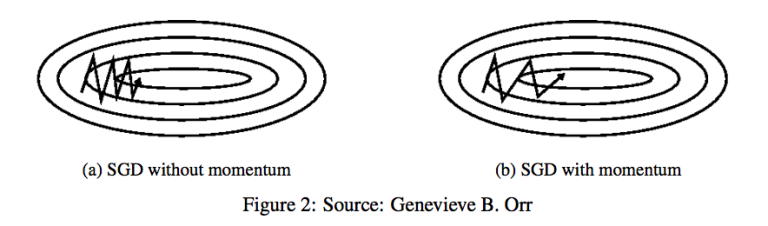



## 위 그래프 처럼 Momentum이 없을 경우 최적화 값을 찾을때 일정한 각도로 내려가지만
## momentum을 지정할 경우 최적화 값에 수렴할때 까지 빠르게 수렴하며 더 잘 작동


In [12]:
for epoch in range(5):  # 데이터셋을 수차례 반복합니다.

    running_loss = 0.000
    for i, data in enumerate(trainloader, 0):
        # 입력을 받은 후,
        inputs, labels = data
        # Variable로 감싸고
        inputs, labels = Variable(inputs), Variable(labels)
        # 변화도 매개변수를 0으로 만든 후
        optimizer.zero_grad()

        # 학습 + 역전파 + 최적화
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계 출력
        
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.460
[1,  4000] loss: 1.094
[1,  6000] loss: 0.888
[1,  8000] loss: 0.811
[1, 10000] loss: 0.746
[1, 12000] loss: 0.704
[1, 14000] loss: 0.686
[1, 16000] loss: 0.667
[2,  2000] loss: 0.582
[2,  4000] loss: 0.570
[2,  6000] loss: 0.556
[2,  8000] loss: 0.557
[2, 10000] loss: 0.548
[2, 12000] loss: 0.547
[2, 14000] loss: 0.530
[2, 16000] loss: 0.535
[3,  2000] loss: 0.428
[3,  4000] loss: 0.447
[3,  6000] loss: 0.440
[3,  8000] loss: 0.430
[3, 10000] loss: 0.434
[3, 12000] loss: 0.437
[3, 14000] loss: 0.430
[3, 16000] loss: 0.443
[4,  2000] loss: 0.321
[4,  4000] loss: 0.337
[4,  6000] loss: 0.330
[4,  8000] loss: 0.345
[4, 10000] loss: 0.362
[4, 12000] loss: 0.364
[4, 14000] loss: 0.357
[4, 16000] loss: 0.374
[5,  2000] loss: 0.250
[5,  4000] loss: 0.250
[5,  6000] loss: 0.268
[5,  8000] loss: 0.273
[5, 10000] loss: 0.278
[5, 12000] loss: 0.307
[5, 14000] loss: 0.316
[5, 16000] loss: 0.287
Finished Training


# 데이터 검증

In [20]:
testset = torchvision.datasets.ImageFolder(root= "C:\\Users\\negga\\Desktop\\AiTest\\data\\pipe",transform=trans)


testloader = DataLoader(testset,
                        batch_size=4,
                        shuffle =True,
                        num_workers = 2)

len(testloader)

classes2 = testset.classes
classes2

['connector', 'crack', 'joint', 'normal', 'sendimentation', 'tubedamage']

torch.Size([4, 3, 100, 100])
(3, 104, 410)
(104, 410, 3)
GroundTruth:  joint crack tubedamage sendimentation


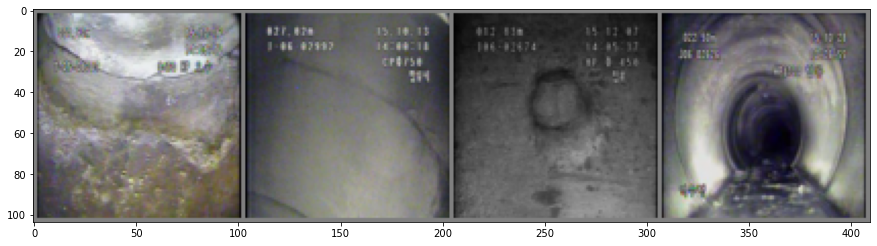

In [21]:
dataiter = iter(testloader)
images, labels = dataiter.next()

print(images.shape)
# 이미지 출력
imgshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [22]:
outputs = net(Variable(images))


_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  joint crack tubedamage sendimentation


In [23]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the test images: %d %%' % (
    100 * correct / total))

Accuracy of the test images: 78 %


In [17]:
## 모델의 학습의 정도를 알기위한 지표로
##정확도(Accuracy),정밀도(precision),재현율(recall), F1 Score(정확률과 정밀도의 조화 평균) 등이 있다.

In [24]:
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))

for data in testloader:
    
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(6):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
    
    
    


Accuracy of connector :  0 %
Accuracy of crack : 78 %
Accuracy of joint : 97 %
Accuracy of normal : 100 %
Accuracy of sendimentation : 97 %
Accuracy of tubedamage : 95 %


In [19]:
x = torch.randn(100,100)
print(x.size())

y=x.view(10000)
print(y.size())

z=x.view(-1,100*100)
print(z.size())

torch.Size([100, 100])
torch.Size([10000])
torch.Size([1, 10000])
